In [1]:
# imports
import numpy as np
import pandas as pd

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

# Ignore wernings
import warnings
warnings.filterwarnings("ignore")

# supress scientific notation
# np.set_printoptions(suppress=True)
plt.rcParams["axes.formatter.limits"] = (-5, 12)
# pd.options.display.float_format = '{:.2f}'.format

# plotting defaults
plt.rc('figure', figsize=(13, 7))
# plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)
plt.rc('figure', figsize=(13, 7))
plt.rc('font', size=16)
plt.style.use('fivethirtyeight')

# Acquire

In [2]:
# load data into a pandas data frame
df = pd.read_csv('Walmart.csv')
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


# Prepare

In [3]:
type(df)

pandas.core.frame.DataFrame

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [5]:
df.shape

(6435, 8)

In [6]:
# Look for empty values
df.isna().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

## Takeaways 
- There are 6435 records 
- 8 Columns
- There are 0 empty values
- Columns have a mix of upper and lower case caracters
    - We will turn them to lower case for 

In [7]:
# Chanege CPI for Consumer Price Index
df.rename(columns={'CPI':'Consumer_Price_Index'}, inplace=True)


In [8]:
# turn the name of the columns to only contain lower case charactes x
df.columns= df.columns.str.lower()
df.columns

Index(['store', 'date', 'weekly_sales', 'holiday_flag', 'temperature',
       'fuel_price', 'consumer_price_index', 'unemployment'],
      dtype='object')

In [9]:
# Ovser that data from has the propper columnbs
df.sample()

,store,date,weekly_sales,holiday_flag,temperature,fuel_price,consumer_price_index,unemployment
162,2,18-06-2010,2001636.96,0,85.81,2.637,211.109654,8.2


In [10]:
# Convert our date column from object type to datetime type
df.date = pd.to_datetime(df.date, format='%d-%m-%Y')
df.dtypes

store                            int64
date                    datetime64[ns]
weekly_sales                   float64
holiday_flag                     int64
temperature                    float64
fuel_price                     float64
consumer_price_index           float64
unemployment                   float64
dtype: object

In [11]:
# # Create features that indicate day, month, year, and weekday
# df['year'] = df.date.dt.year
# df['month'] = df.date.dt.month
# df['day'] = df.date.dt.month
# df['weekday'] = df.date.dt.day_name()
# df.head()

In [12]:
# set the date as index
df = df.set_index('date', drop=True).sort_index()


# Exploratory Analysis

In [13]:
df.index.nunique() # number of unique sales dates

143

In [14]:
# See the full data set
from IPython.display import HTML

HTML(df.to_html())

,store,weekly_sales,holiday_flag,temperature,fuel_price,consumer_price_index,unemployment
date,,,,,,,
2010-02-05,1,1643690.90,0,42.31,2.572,211.096358,8.106
2010-02-05,10,2193048.75,0,54.34,2.962,126.442065,9.765
2010-02-05,37,536006.73,0,45.97,2.572,209.852966,8.554
2010-02-05,17,789036.02,0,23.11,2.666,126.442065,6.548
2010-02-05,30,465108.52,0,39.05,2.572,210.752605,8.324
2010-02-05,25,677231.63,0,21.10,2.784,204.247194,8.187
2010-02-05,22,1033017.37,0,24.36,2.788,135.352461,8.283
2010-02-05,23,1364721.58,0,15.25,2.788,131.527903,5.892
2010-02-05,24,1388725.63,0,22.43,2.954,131.527903,8.326


In [15]:
# what dates does your data set cover
df.index.min(), df.index.max()

(Timestamp('2010-02-05 00:00:00'), Timestamp('2012-10-26 00:00:00'))

In [16]:
df.weekly_sales.describe()

count    6.435000e+03
mean     1.046965e+06
std      5.643666e+05
min      2.099862e+05
25%      5.533501e+05
50%      9.607460e+05
75%      1.420159e+06
max      3.818686e+06
Name: weekly_sales, dtype: float64

- Hour data set covers almost three years of data

In [17]:
df.nunique().sort_values()

holiday_flag               2
store                     45
unemployment             349
fuel_price               892
consumer_price_index    2145
temperature             3528
weekly_sales            6435
dtype: int64

<AxesSubplot:xlabel='date'>

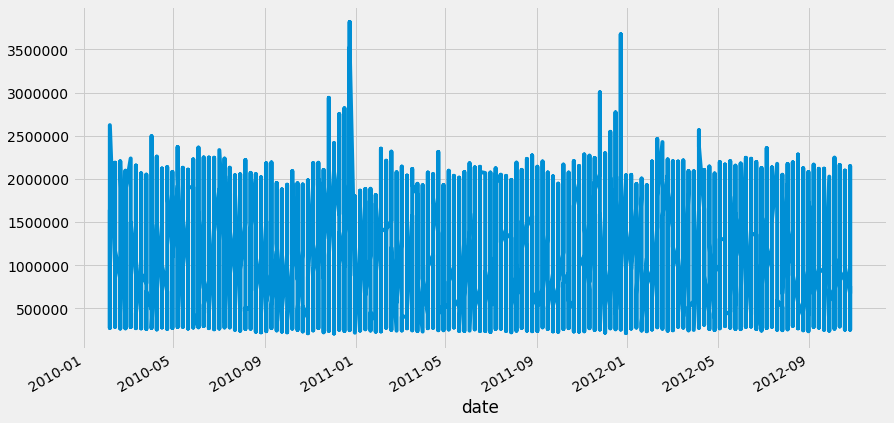

In [18]:
#lets visulize our data
df.weekly_sales.plot()

<AxesSubplot:xlabel='date'>

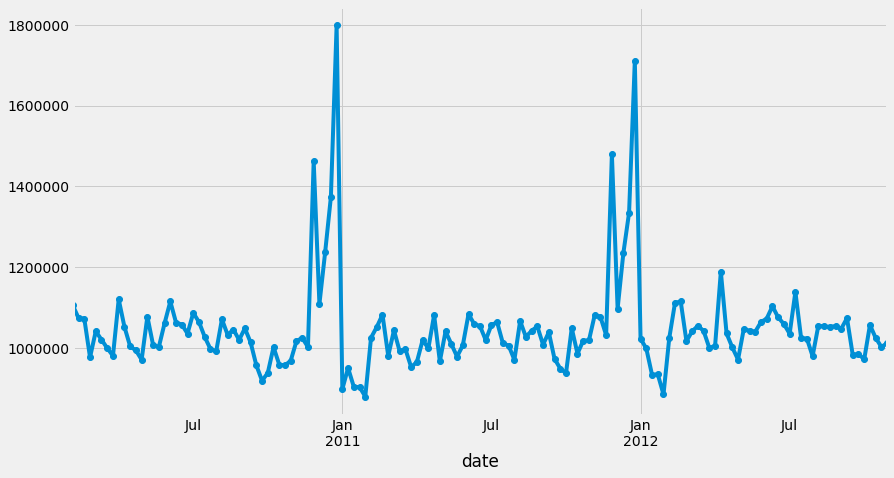

In [19]:
#  let's visualize Theden by quarter# Lets resomaple our data into monthly vlaues
df.weekly_sales.resample('W').mean().plot(marker='o')

<AxesSubplot:xlabel='date'>

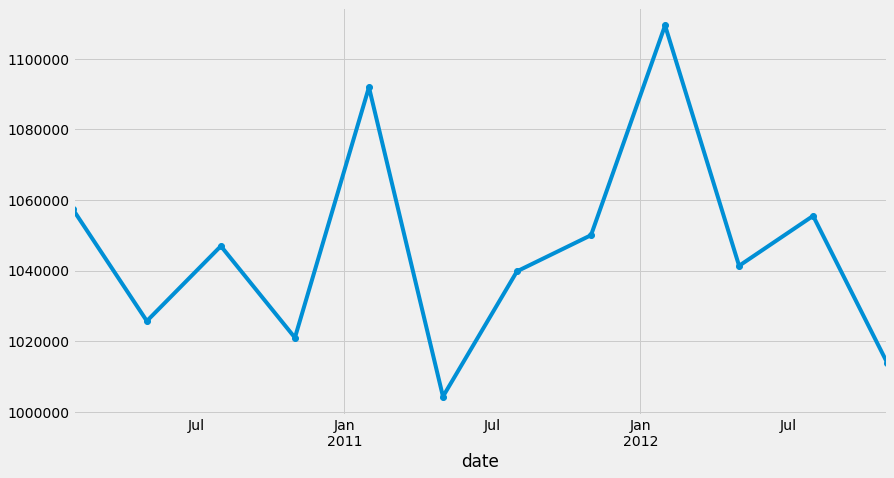

In [20]:
#  let's visualize Theden by quarter# Lets resomaple our data into monthly vlaues
df.weekly_sales.resample('3M').mean().plot(marker='o')

<AxesSubplot:xlabel='date'>

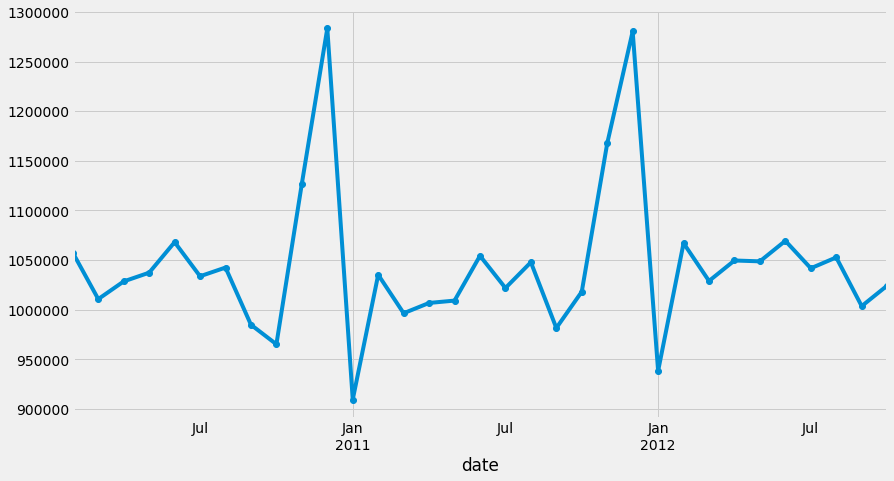

In [21]:
# Lets resomaple our data into monthly vlaues
df.weekly_sales.resample('M').mean().plot(marker='o')

,weekly_sales,rolling_3,rolling_5,rolling_7
date,,,,
2010-02-07,1.105572e+06,NaN,NaN,NaN
2010-02-14,1.074148e+06,NaN,NaN,NaN
2010-02-21,1.072822e+06,1.084181e+06,NaN,NaN
2010-02-28,9.770794e+05,1.041350e+06,NaN,NaN
2010-03-07,1.041588e+06,1.030497e+06,1.054242e+06,NaN
2010-03-14,1.020564e+06,1.013077e+06,1.037240e+06,NaN
2010-03-21,9.997550e+05,1.020636e+06,1.022362e+06,1.041647e+06
2010-03-28,9.807547e+05,1.000358e+06,1.003948e+06,1.023816e+06
2010-04-04,1.120530e+06,1.033680e+06,1.032638e+06,1.030442e+06


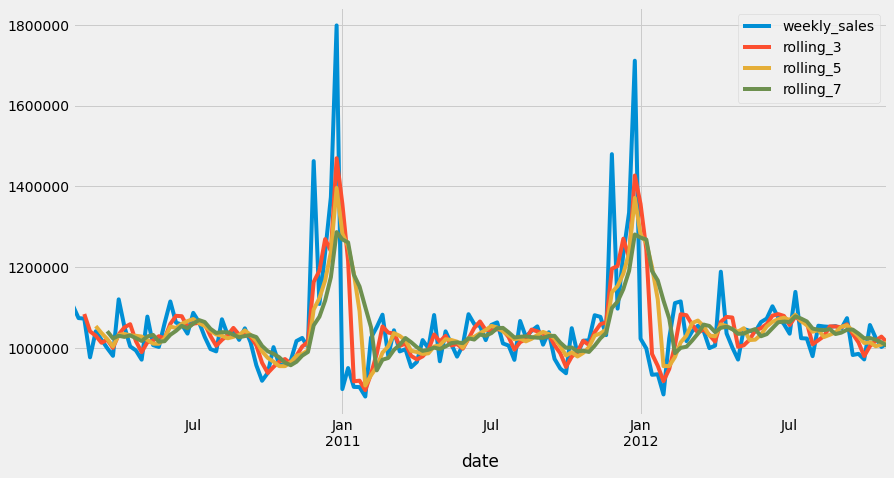

In [22]:
# Rolling Averages evry week
rolling_df = df.resample('w').mean().assign(
    rolling_3=lambda df: df.weekly_sales.rolling(3).mean(),
    rolling_5=lambda df: df.weekly_sales.rolling(5).mean(),
    rolling_7=lambda df: df.weekly_sales.rolling(7).mean(),
)
# delete colums to see targets rolling averages in 2 wweks, a month and quarterly
# del rolling_df['weekly_sales']
del rolling_df['store']
del rolling_df['holiday_flag']
del rolling_df['temperature']
del rolling_df['fuel_price']
del rolling_df['consumer_price_index']
del rolling_df['unemployment']
rolling_df.plot()
rolling_df.head(20)

,weekly_sales,rolling_3,rolling_5,rolling_7
date,,,,
2010-02-07,1.105572e+06,NaN,NaN,NaN
2010-02-21,1.073485e+06,NaN,NaN,NaN
2010-03-07,1.009334e+06,1.062797e+06,NaN,NaN
2010-03-21,1.010160e+06,1.030993e+06,NaN,NaN
2010-04-04,1.050642e+06,1.023379e+06,1.049839e+06,NaN
2010-04-18,1.028322e+06,1.029708e+06,1.034389e+06,NaN
2010-05-02,9.826620e+05,1.020542e+06,1.016224e+06,1.037168e+06
2010-05-16,1.042592e+06,1.017859e+06,1.022876e+06,1.028171e+06
2010-05-30,1.031973e+06,1.019076e+06,1.027238e+06,1.022241e+06


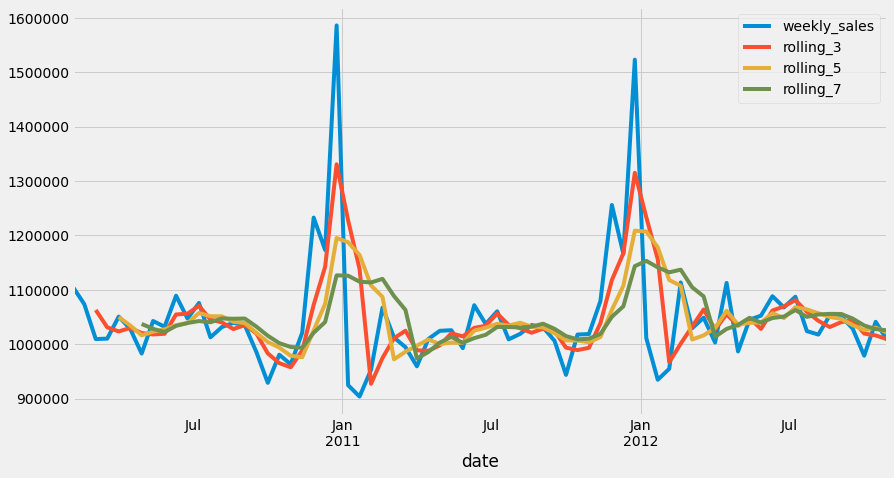

In [23]:
# Rolling Averages for dara downsampled to every 2 weeks 
rolling_df = df.resample('2W').mean().assign(
    rolling_3=lambda df: df.weekly_sales.rolling(3).mean(),
    rolling_5=lambda df: df.weekly_sales.rolling(5).mean(),
    rolling_7=lambda df: df.weekly_sales.rolling(7).mean(),
)

# delete colums to see targets rolling averages in 2 wweks, a month and quarterly
# del rolling_df['weekly_sales']
del rolling_df['store']
del rolling_df['holiday_flag']
del rolling_df['temperature']
del rolling_df['fuel_price']
del rolling_df['consumer_price_index']
del rolling_df['unemployment']
rolling_df.plot()
rolling_df.head(20)

In [24]:
df.sample()

,store,weekly_sales,holiday_flag,temperature,fuel_price,consumer_price_index,unemployment
date,,,,,,,
2011-10-21,15,603318.89,0,51.67,3.757,136.501774,7.866


## Takeaways
- Or data comes from the sales of *143 weeks* for *45 stores*  
- Our data runs from **2010-01-10'** to **'2012-12-10'**
- Walmart seems to experience seasonality around the months of November and December
- Ther are alot of gaps in daily data
    -Data set before split need to downsampled to evry 2 weeks so that there are no gaps 
-  Data does not seem to be arrange daily
    - Farther explore how data is arrangeded 


# Split

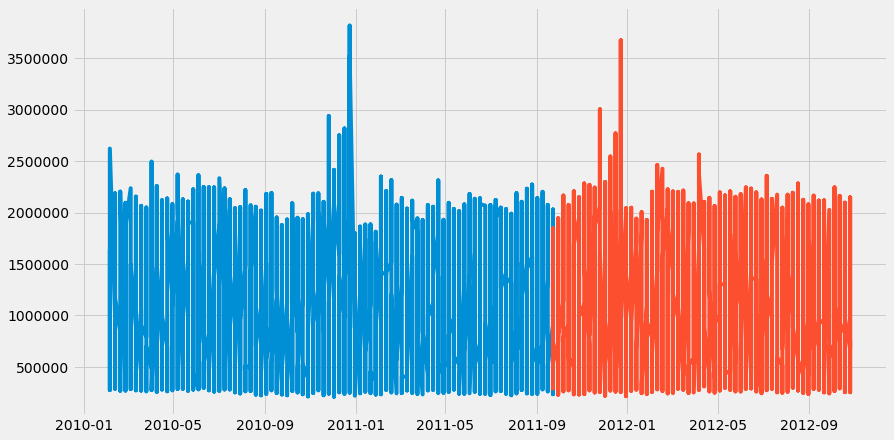

In [25]:
# Use percentage methodes to split
train_size = .60
n = df.shape[0]
test_start_index = round(train_size * n)

train = df[:test_start_index] # everything up (not including) to the test_start_index
test = df[test_start_index:] # everything from the test_start_index to the end

plt.plot(train.index, train.weekly_sales)
plt.plot(test.index, test.weekly_sales)

In [26]:
# eliminate all variables from train and test exept target 
train = train['weekly_sales']
test = test['weekly_sales']


In [27]:
# Establish taget 
y = df.weekly_sales
y.head(), y.shape

(date
 2010-02-05    1643690.90
 2010-02-05    2193048.75
 2010-02-05     536006.73
 2010-02-05     789036.02
 2010-02-05     465108.52
 Name: weekly_sales, dtype: float64,
 (6435,))

# EDA After Split

<AxesSubplot:ylabel='Frequency'>

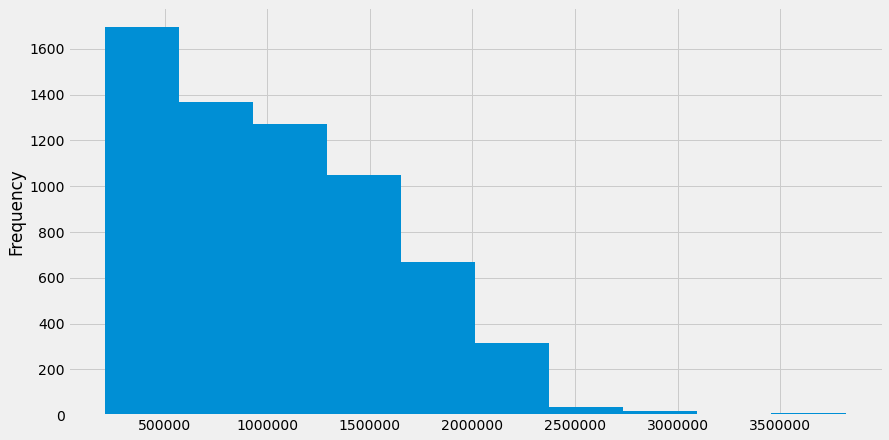

In [28]:
y.plot.hist()

[Text(0.5, 1.0, 'Average Sales by Month'),
 Text(0.5, 0, 'Month'),
 Text(0, 0.5, 'Sales $US')]

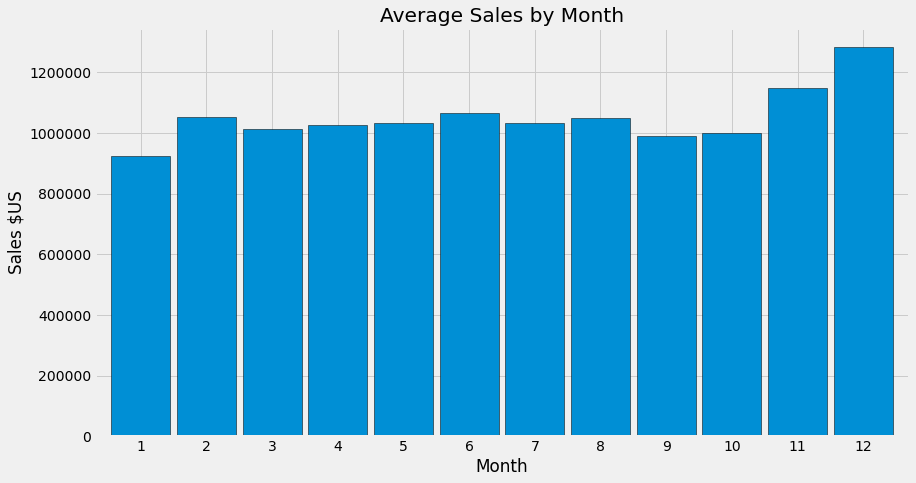

In [29]:
ax = y.groupby(y.index.month).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Average Sales by Month', xlabel='Month', ylabel='Sales $US')

[Text(0.5, 1.0, 'Average Sales by Month'),
 Text(0.5, 25.200000000000003, 'Week number'),
 Text(25.200000000000003, 0.5, '$US')]

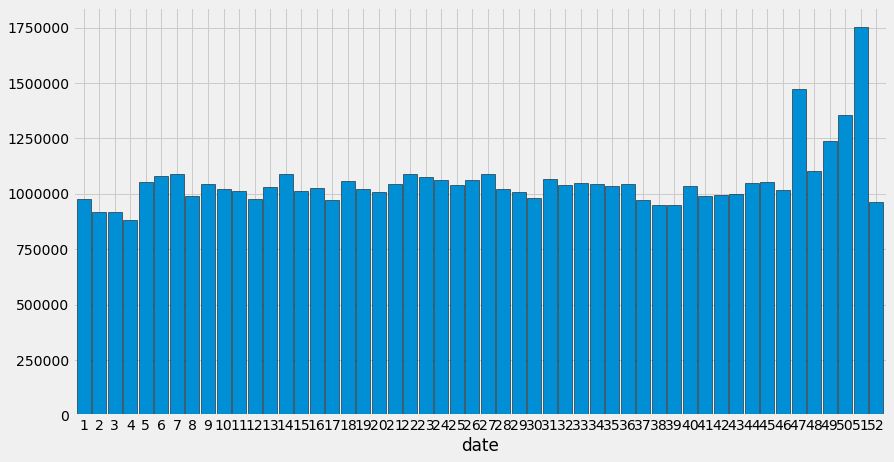

In [30]:
y.groupby(y.index.week).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Average Sales by Month', xlabel='Week number', ylabel='$US')



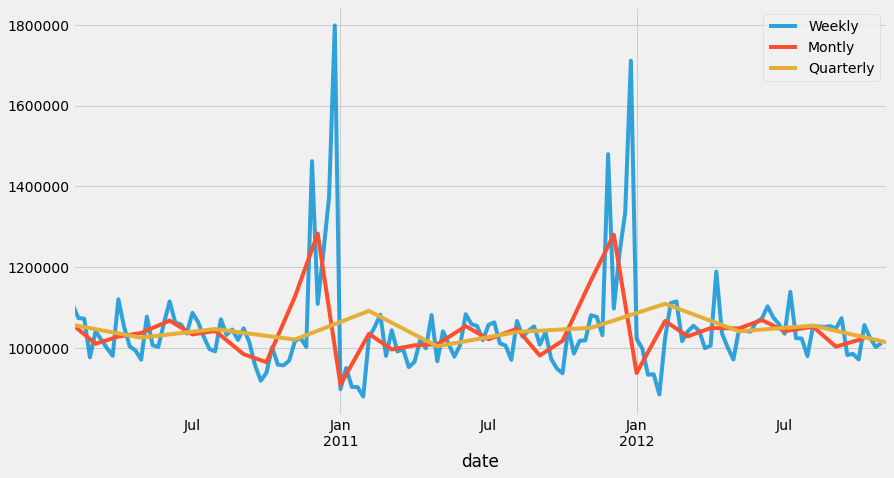

In [31]:
y.resample('W').mean().plot(alpha=.8, label='Weekly')
y.resample('M').mean().plot(label='Montly')
y.resample('3M').mean().plot(label='Quarterly')
plt.legend()


- Seasonality is evident for November, December, and January
- Normal distribution can be observed
- Week 47 shows seasonality 
- From the first week of February, sales start to pick up
- Second-quarter seems to have a drop in sales to pick up in summer

--------------

# Modeling/ Forecasting

The following funcitons will be helpful in evaluating each of the forcasting methods.

In [33]:
# Set target variable
target_var = 'weekly_sales'

In [34]:
# evaluation function to compute rmse
def evaluate(target_var):
    """
    will compute the Mean Squared Error and the Rood Mean Squared Error to evaluate.
    """
    rmse = round(sqrt(mean_squared_error(train[target_var], yhat_df[target_var])), 0)
    return rmse

In [35]:
# plot and evaluate 
def plot_and_eval(target_var):
    """
    Function will plot train and test values with the predicted
    values in order to compare performance.
    """
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = test(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()


In [36]:
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    """
    append evaluation metrics for each model type, target variable, and metric 
    type, along with the metric value into our eval_df data frame object. Which 
    we will create an empty eval_df dataframe object to start.
    """
    rmse = test(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

### Forcassting predictions

In [37]:
################ Last observed value ##################
"""
predicts all future values to be the last observed value.
"""
# Predicions

dollars = round(train['weekly_sales'][-1:][0],2)

yhat_df = pd.DataFrame({'weekly_sales': [dollars]}, 
                       index = train.index)

yhat_df.head(2)

KeyError: 'weekly_sales'

In [ ]:
train

In [ ]:
for col in train:
    eval_df = append_eval_df(model_type = 'last_observed_value', target_var = target_var)

In [ ]:
eval_df